In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle as pkl
import torch.nn.functional as F

In [2]:
# Hyperparms
num_workers = 0
batch_size = 64
transform = transforms.ToTensor()
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)


Extracting data\MNIST\raw\train-images-idx3-ubyte.gz to data\MNIST\raw



Extracting data\MNIST\raw\train-labels-idx1-ubyte.gz to data\MNIST\raw



Extracting data\MNIST\raw\t10k-images-idx3-ubyte.gz to data\MNIST\raw



Extracting data\MNIST\raw\t10k-labels-idx1-ubyte.gz to data\MNIST\raw
Processing...
Done!


In [4]:
# Discriminator class
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_layer, output_size):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer*4)
        self.fc2 = nn.Linear(hidden_layer*4, hidden_layer*2)
        self.fc3 = nn.Linear(hidden_layer*2, hidden_layer)
        self.fc4 = nn.Linear(hidden_layer, output_size)
        
        # Drop out layer
        self.dropout = nn.Dropout(0.3)
    
    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.leaky_relu(self.fc1(x), 0.2) # Negative slope of 0.2
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer
        out = self.fc4(x)
        return out
        
        

In [5]:
# Generator
class Generator(nn.Module):
    def __init__(self, input_size, hidden_layer, output_size):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer)
        self.fc2 = nn.Linear(hidden_layer, hidden_layer*2)
        self.fc3 = nn.Linear(hidden_layer*2, hidden_layer*4)
        self.fc4 = nn.Linear(hidden_layer*4, output_size)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
    def forward(self,x):
        x = F.leaky_relu(self.fc1(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # final layer with tanh applied
        out = F.tanh(self.fc4(x))

        return out
        

In [6]:
# More hyperparams
# Discriminator parmas
input_size = 784 #28*28*1 image shape
disc_output_size = 1 # discrimintor output prediciton of 0-9
disc_hidden_size = 32 # Size of last hidden layer of discriminator

# Generator params
z_size = 100 # Latent vector for gen
gen_output_size = 784
gen_hidden_size = 32 # First layer of generator

In [7]:
Disc = Discriminator(input_size, disc_hidden_size, disc_output_size)
Gen = Generator(z_size, gen_hidden_size, gen_output_size)
print(Disc)
print()
print(Gen)


Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


In [8]:
# Losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # Check for label smoothing
    if smooth:
        labels = torch.ones(batch_size)*0.9 # real label never = 1 helps with overfitting
    else:
        labels = torch.ones(batch_size) # real labes = 1
        
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # Fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [9]:
# Optimizer
lr = 0.002
d_optimizer = optim.Adam(Disc.parameters(), lr)
g_optimizer = optim.Adam(Gen.parameters(), lr)

In [11]:
# Training
num_epochs = 100
samples = [] # Store fake samples for loss and generated
losses = []

print_every = 400

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# Set models for training
Disc.train()
Gen.train()
for epoch in range(num_epochs):
    # Each batch
    for batch_i, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        # rescale input images from [0,1) to [-1, 1)
        real_images = real_images*2 - 1
        # Train Discriminator
        d_optimizer.zero_grad()
        # Train with real images
        D_real = Disc(real_images)
        d_real_loss = real_loss(D_real, smooth=True) # Use label smoothing
        
        # Next step train with fake images
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size)) # Random Noise
        z = torch.from_numpy(z).float() # Convert to a flot
        fake_images = Gen(z) # Predict with Generator (DO NOT TRAIN GENERATOR HERE) train one at a time
        
        # Computer fake loss
        D_fake = Disc(fake_images)
        d_fake_loss = fake_loss(D_fake)
        # add up loss and back prop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        '''
        # Generator training
        '''
        g_optimizer.zero_grad()
        # Generator fake images and train
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = Gen(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = Disc(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()
        
        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
    
    ## AFTER EACH EPOCH##
    # append discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    Gen.eval() # eval mode for generating samples
    samples_z = Gen(fixed_z)
    samples.append(samples_z)
    Gen.train() # back to train mode

        
        
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)        

C:\Users\matthew.millar\Anaconda3\envs\TF2\lib\site-packages\torch\nn\functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.3786 | g_loss: 0.7460
Epoch [    1/  100] | d_loss: 0.7786 | g_loss: 3.5885
Epoch [    1/  100] | d_loss: 0.9441 | g_loss: 1.8672
Epoch [    2/  100] | d_loss: 0.7789 | g_loss: 4.2459
Epoch [    2/  100] | d_loss: 0.8597 | g_loss: 1.9324
Epoch [    2/  100] | d_loss: 0.8680 | g_loss: 2.0637
Epoch [    3/  100] | d_loss: 0.8723 | g_loss: 1.8981
Epoch [    3/  100] | d_loss: 1.0049 | g_loss: 1.6940
Epoch [    3/  100] | d_loss: 0.9210 | g_loss: 2.8194
Epoch [    4/  100] | d_loss: 1.0601 | g_loss: 1.7410
Epoch [    4/  100] | d_loss: 1.3777 | g_loss: 1.1276
Epoch [    4/  100] | d_loss: 1.0553 | g_loss: 1.6440
Epoch [    5/  100] | d_loss: 1.1426 | g_loss: 1.6498
Epoch [    5/  100] | d_loss: 1.1160 | g_loss: 1.2391
Epoch [    5/  100] | d_loss: 1.2102 | g_loss: 1.4780
Epoch [    6/  100] | d_loss: 0.9962 | g_loss: 1.5166
Epoch [    6/  100] | d_loss: 1.2997 | g_loss: 1.1244
Epoch [    6/  100] | d_loss: 1.1968 | g_loss: 1.1527
Epoch [    7/  100] | d_loss

Epoch [   51/  100] | d_loss: 1.2617 | g_loss: 0.7775
Epoch [   51/  100] | d_loss: 1.2079 | g_loss: 1.2474
Epoch [   52/  100] | d_loss: 1.2757 | g_loss: 0.9746
Epoch [   52/  100] | d_loss: 1.2529 | g_loss: 1.1741
Epoch [   52/  100] | d_loss: 1.3287 | g_loss: 0.9975
Epoch [   53/  100] | d_loss: 1.1873 | g_loss: 1.9806
Epoch [   53/  100] | d_loss: 1.3176 | g_loss: 1.1087
Epoch [   53/  100] | d_loss: 1.2142 | g_loss: 1.0127
Epoch [   54/  100] | d_loss: 1.2415 | g_loss: 0.9391
Epoch [   54/  100] | d_loss: 1.2090 | g_loss: 1.1199
Epoch [   54/  100] | d_loss: 1.2758 | g_loss: 0.9962
Epoch [   55/  100] | d_loss: 1.3333 | g_loss: 1.0166
Epoch [   55/  100] | d_loss: 1.3018 | g_loss: 0.9272
Epoch [   55/  100] | d_loss: 1.1783 | g_loss: 1.3152
Epoch [   56/  100] | d_loss: 1.2556 | g_loss: 1.0423
Epoch [   56/  100] | d_loss: 1.2810 | g_loss: 0.8794
Epoch [   56/  100] | d_loss: 1.3123 | g_loss: 0.8958
Epoch [   57/  100] | d_loss: 1.2831 | g_loss: 0.8796
Epoch [   57/  100] | d_loss

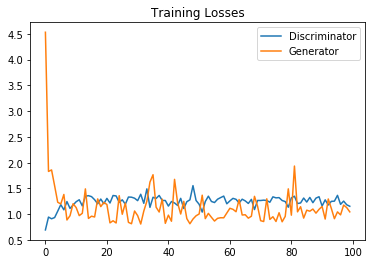

In [12]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [13]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [14]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

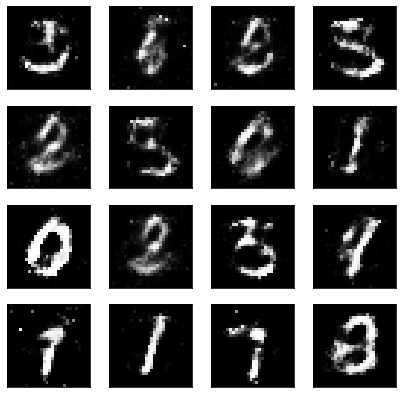

In [15]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

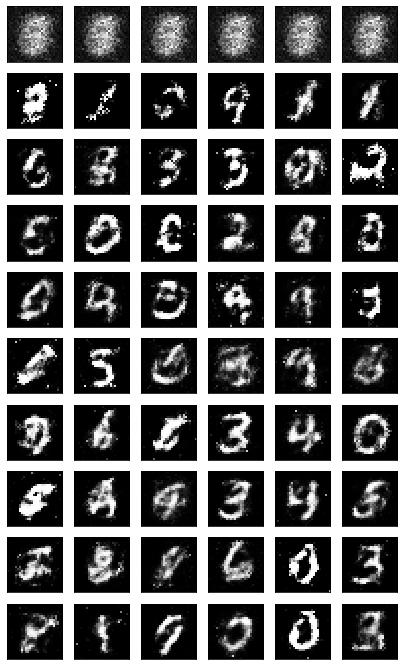

In [16]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

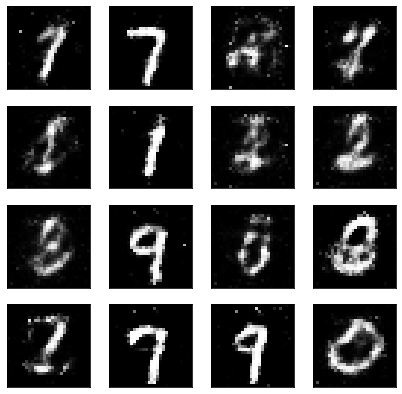

In [17]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

Gen.eval() # eval mode
# generated samples
rand_images = Gen(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])